# Install libraries and imports

In [1]:
# !pip install tensorflow
# !pip install yfinance --upgrade --no-cache-dir

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
import math
from sklearn.metrics import mean_squared_error
import yfinance as yf

2024-06-13 13:32:31.223629: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 13:32:31.226115: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 13:32:31.259649: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 13:32:31.895296: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Get data form yahoo

In [3]:
msft = yf.Ticker("NVDA")

# get historical market data
hist = msft.history(period="max")

In [4]:
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1999-01-22 00:00:00-05:00,0.040129,0.044786,0.035590,0.037621,2714688000,0.0,0.0
1999-01-25 00:00:00-05:00,0.040607,0.042039,0.037621,0.041562,510480000,0.0,0.0
1999-01-26 00:00:00-05:00,0.042039,0.042876,0.037740,0.038337,343200000,0.0,0.0
1999-01-27 00:00:00-05:00,0.038457,0.039412,0.036307,0.038218,244368000,0.0,0.0
1999-01-28 00:00:00-05:00,0.038218,0.038457,0.037859,0.038098,227520000,0.0,0.0


# Data Analysis - Plots

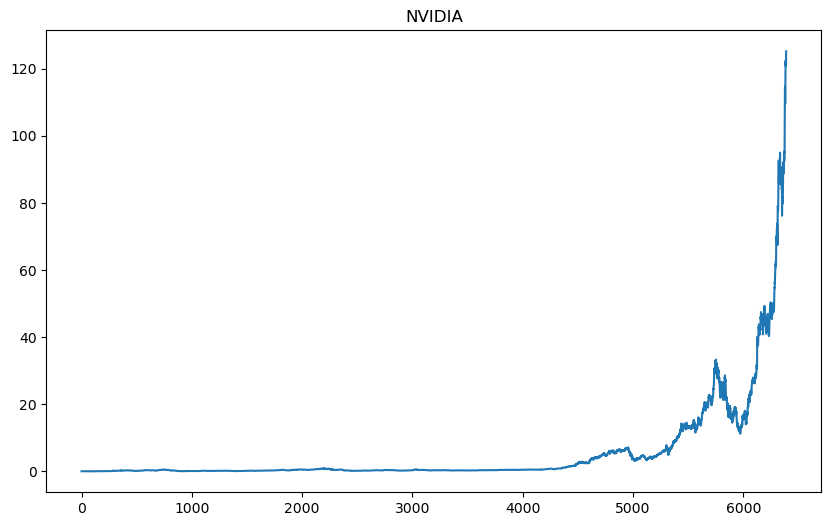

In [5]:
df2 = hist.reset_index()['Close']

plt.figure(figsize=(10, 6))
plt.plot(df2)
plt.title("NVIDIA")
plt.show()

# Data Preprocessing

In [6]:
scaler = MinMaxScaler()
df2 = scaler.fit_transform(np.array(df2).reshape(-1,1))
df2.shape

(6389, 1)

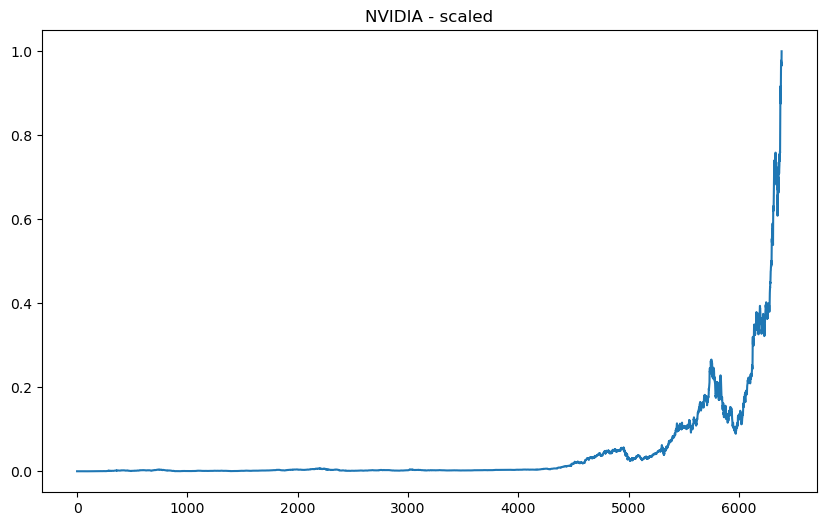

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(df2)
plt.title("NVIDIA - scaled")
plt.show()

## Train-Test split

In [8]:
train_size = int(len(df2)*0.65)
test_size = len(df2) - train_size
train_data,test_data = df2[0:train_size,:],df2[train_size:len(df2),:1]

A function is created as create_dataset() which splits the dataset into 2 based on the time step we take. The first dataset i.e.; dataX takes the values as its input and the second dataset dataY takes the values as output. Basically it creates a dataset matrix from the above dataset.

In [9]:
def create_dataset(dataset, time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
                   a = dataset[i:(i+time_step),0] # TODO: dont add the second column here just reshape later
                   dataX.append(a)
                   dataY.append(dataset[i + time_step,0])
    return np.array(dataX),np.array(dataY)

`time_step` is described by the amount of data of days given for 1 prediction. (For example by setting `time_step`=100, we give the model 100 days of data to predict the 101 day)

In [10]:
# calling the create dataset function to split the data into 
# input output datasets with time step 100
time_step = 100 
X_train,Y_train =  create_dataset(train_data,time_step)
X_test,Y_test =  create_dataset(test_data,time_step)

In [11]:
# checking values
print(X_train.shape)
print(X_train)
print(X_test.shape)
print(Y_test.shape)

(4051, 100)
[[5.05700366e-05 8.20580979e-05 5.62931798e-05 ... 2.00345428e-05
  9.54103229e-06 9.54103229e-06]
 [8.20580979e-05 5.62931798e-05 5.53405528e-05 ... 9.54103229e-06
  9.54103229e-06 1.71694295e-05]
 [5.62931798e-05 5.53405528e-05 5.43805447e-05 ... 9.54103229e-06
  1.71694295e-05 9.54103229e-06]
 ...
 [4.01237024e-03 4.02392081e-03 3.99696916e-03 ... 3.56985034e-03
  3.65494939e-03 3.63174134e-03]
 [4.02392081e-03 3.99696916e-03 4.10092812e-03 ... 3.65494939e-03
  3.63174134e-03 3.56018002e-03]
 [3.99696916e-03 4.10092812e-03 4.02007126e-03 ... 3.63174134e-03
  3.56018002e-03 3.57758636e-03]]
(2136, 100)
(2136,)


# Create Model

In [12]:
model = Sequential()
model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer = 'adam')

2024-06-13 13:32:34.275406: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-13 13:32:34.278947: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/thanos/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 100,batch_size = 64,verbose = 10)

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 4.6151e-05 - val_loss: 0.0417
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 1.5831e-06 - val_loss: 0.0381
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 1.4007e-06 - val_loss: 0.0321
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 1.1547e-06 - val_loss: 0.0187
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 6.1532e-07 - val_loss: 0.0032
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 1.6704e-07 - val_loss: 0.0033
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 1.7841e-07 - val_loss: 0.0031
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 1.8635e-07 - val_loss: 0.0029
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 1.0944e-07 - val_loss: 0.0033
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 1.4420e-07 - val_loss: 0.0030
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 1.7946e-07 - val_loss: 0.0029
Epoch 12

In [15]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# transform to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


## Plotting the results

Lookback variable takes the number of values behind the current value i.e.; remembering the previous 100 values which is as same as LSTM. Here every time while plotting the graph, the trainPredictionPlot will take 100 values behind them and plot it. and the plotting goes from previous 100th value and goes till the length of the trainpredict + the lookback i.e.; 100.

In [16]:
look_back = 100

trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back,:] = train_predict

testPredictPlot = np.empty_like(df2)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back)*2 + 1 : len(df2) - 1,:] = test_predict

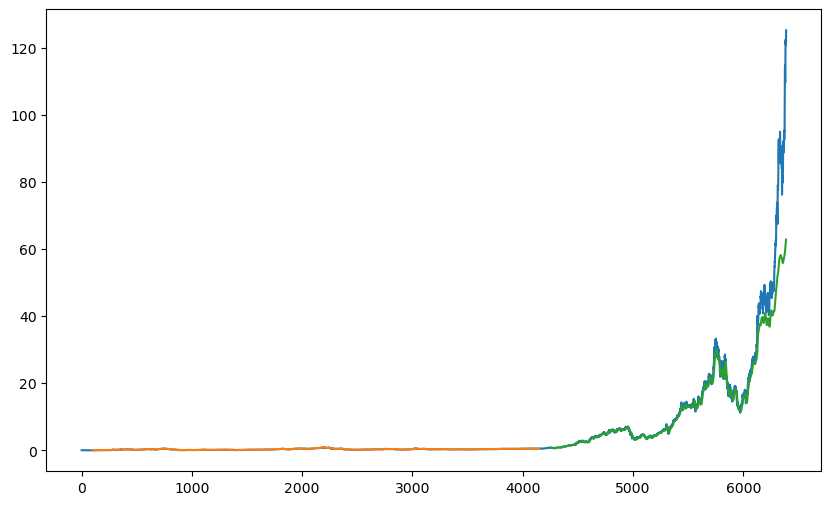

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
# plt.legend()
plt.show()

# BI-LSTM approach

In [18]:
model = Sequential()
# Adding Bidirectional LSTM layers
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Bidirectional(LSTM(50)))
# Adding Dense layer
model.add(Dense(1))

# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')

/home/thanos/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 100, 100)       │        20,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100, 100)       │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,701 (553.52 KB)

 Trainable params: 141,701 (553.52 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 100,batch_size = 64,verbose = 1)

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - loss: 6.0318e-05 - val_loss: 0.0404
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 1.6689e-06 - val_loss: 0.0371
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 1.3632e-06 - val_loss: 0.0321
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 1.1720e-06 - val_loss: 0.0231
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 7.9723e-07 - val_loss: 0.0077
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 2.7175e-07 - val_loss: 0.0045
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 1.2747e-07 - val_loss: 0.0036
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 1.4088e-07 - val_loss: 0.0035
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 1.2550e-07 - val_loss: 0.0035
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 1.3899e-07 - val_loss: 0.0035
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 1.1230e-07 - val_loss: 0.0036
Epoch 1

In [28]:
train_predict2 = model.predict(X_train)
test_predict2 = model.predict(X_test)

# transform to original form
train_predict2 = scaler.inverse_transform(train_predict2)
test_predict2 = scaler.inverse_transform(test_predict2)

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [29]:
look_back = 100

trainPredictPlot2 = np.empty_like(df2)
trainPredictPlot2[:,:] = np.nan
trainPredictPlot2[look_back : len(train_predict2)+look_back,:] = train_predict2

testPredictPlot2 = np.empty_like(df2)
testPredictPlot2[:,:] = np.nan
testPredictPlot2[len(train_predict2)+(look_back)*2 + 1 : len(df2) - 1,:] = test_predict2

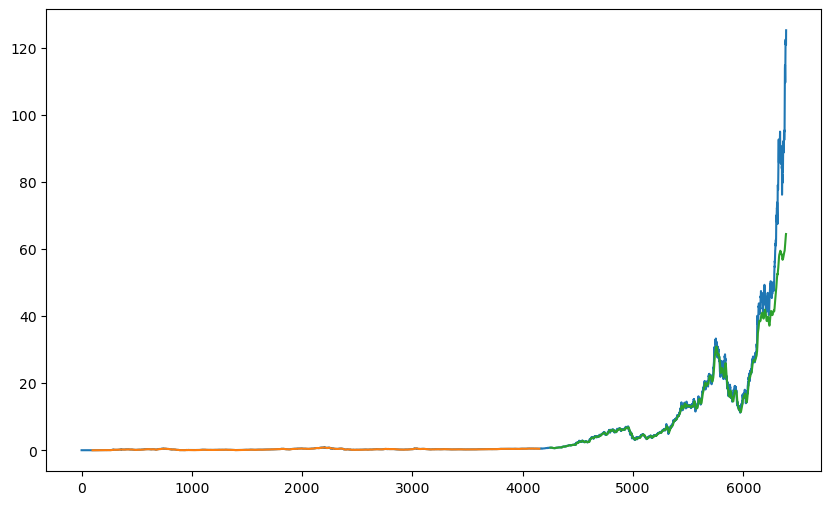

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot2)
plt.plot(testPredictPlot2)
# plt.legend()
plt.show()